## Perturbation classifier - distinguish ctrl from all the perturbations

### Imports

In [1]:
import scanpy as scp
import pandas as pd
import numpy as np
import catboost as cb
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import StratifiedKFold

### Magics

In [33]:
GENE_PER_CELL_BINNING = False
N_BINS = 1000
N_ITER = 50
TOP_N_GENES = 500

### Step 0

In [34]:
adata = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [35]:
## Following the scGPT paper, we bin the genes within cell. 

def bin_nonzero_values(arr, num_bins):
    # Filter out non-zero values
    nonzero_vals = arr[arr != 0]
    
    # Calculate bin edges
    bin_edges = np.linspace(nonzero_vals.min(), nonzero_vals.max(), num_bins)
    
    # Bin the values
    binned_values = np.zeros_like(arr)
    binned_nonzero = np.digitize(nonzero_vals, bin_edges)
    binned_values[arr != 0] = binned_nonzero
    
    return binned_values

# Example usage
arr = np.random.randint(low=0, high=100, size=100)
num_bins = 3
binned_values = bin_nonzero_values(arr, num_bins)
print(set(binned_values))

{0, 1, 2, 3}


In [36]:
scp.pp.normalize_total(adata, exclude_highly_expressed=True)
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata, n_top_genes=TOP_N_GENES,subset=True)

In [37]:
if GENE_PER_CELL_BINNING:
    tempy = adata.X.toarray()
    
    for c in tqdm(range(adata.X.shape[0])):
        tempy[c,:] = bin_nonzero_values(tempy[c,:], N_BINS)
    
    adata.X = sparse.csr_matrix(tempy)
    del tempy

In [87]:
y = adata.obs.condition.values.astype(str)
X = adata.X.toarray()

In [88]:
y

array(['TSC22D1+ctrl', 'KLF1+MAP2K6', 'ctrl', ..., 'CELF2+ctrl',
       'BCORL1+ctrl', 'MAP4K3+ctrl'], dtype='<U15')

In [89]:
def binarize(yi):
    yi[yi=='ctrl']
    yi[yi == 'ctrl'] = '1'
    yi[yi!='1'] = '0'
    yi = yi.astype(int)
    return yi

In [90]:
# reducer = umap.UMAP(n_neighbors=10,verbose=True)
# embedding = reducer.fit_transform(X)

# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# colors = encoder.fit_transform(y)

# plt.scatter(embedding[:,0],embedding[:,1], c=colors, alpha=0.1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )
y_train_b = binarize(y_train.copy())
y_val_b = binarize(y_val.copy())
y_test_b = binarize(y_test.copy())

model = LGBMClassifier(verbose=-1, n_jobs=10,n_estimators=3000)
model.fit(X_train, y_train_b, eval_set=[(X_val, y_val_b)], eval_metric='logloss',    callbacks=[
        lgb.early_stopping(stopping_rounds=300),
        lgb.log_evaluation(10)
    ])

Training until validation scores don't improve for 300 rounds
[10]	valid_0's binary_logloss: 0.243476
[20]	valid_0's binary_logloss: 0.232405
[30]	valid_0's binary_logloss: 0.227815
[40]	valid_0's binary_logloss: 0.224858
[50]	valid_0's binary_logloss: 0.222711
[60]	valid_0's binary_logloss: 0.221889
[70]	valid_0's binary_logloss: 0.221367
[80]	valid_0's binary_logloss: 0.221419
[90]	valid_0's binary_logloss: 0.221399
[100]	valid_0's binary_logloss: 0.221413
[110]	valid_0's binary_logloss: 0.221307
[120]	valid_0's binary_logloss: 0.221118
[130]	valid_0's binary_logloss: 0.221087
[140]	valid_0's binary_logloss: 0.221158
[150]	valid_0's binary_logloss: 0.22124
[160]	valid_0's binary_logloss: 0.221172
[170]	valid_0's binary_logloss: 0.221288
[180]	valid_0's binary_logloss: 0.22108
[190]	valid_0's binary_logloss: 0.221326
[200]	valid_0's binary_logloss: 0.221351
[210]	valid_0's binary_logloss: 0.221475
[220]	valid_0's binary_logloss: 0.221565
[230]	valid_0's binary_logloss: 0.221754
[240]	

LGBMClassifier(n_estimators=3000, n_jobs=10, verbose=-1)

In [92]:
y_pred_proba=model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)


In [93]:
from sklearn.metrics import f1_score

f1_score(y_test_b, y_pred)

0.07685810810810811

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

def plot_roc_pr_curves(y_true, y_prob):
    """
    Compute and plot ROC-AUC and PR-AUC curves.

    Parameters:
    y_true (array-like): True binary labels (0 or 1).
    y_prob (array-like): Predicted probabilities of the positive class.

    Returns:
    None (plots ROC and PR curves).
    """

    # Compute ROC curve and ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)

    # Compute precision-recall curve and PR-AUC
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    # Plot ROC curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Plot PR curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='red', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

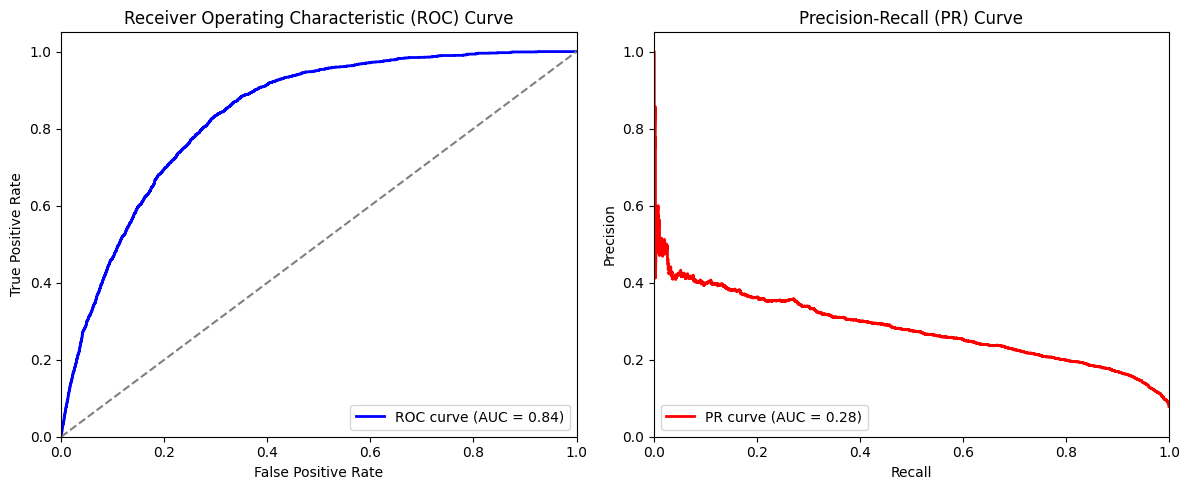

In [114]:
plot_roc_pr_curves(y_test_b, y_pred_proba[:,1])

In [100]:
from collections import Counter
fails = dict(Counter(y_test[y_pred != y_test_b]))

In [105]:
tfs = pd.read_csv('TF_db.csv',index_col=0)
tfs = tfs['HGNC symbol'].tolist()

In [112]:
print('The following TFs were perturbed AND misclassified:\n\n')
for p in fails.keys():
    temp = p.split('+')
    for i in temp:
        if i in tfs:
            print(p, fails[p])

The following TFs were perturbed AND misclassified:


MAPK1+TGFBR2 1
ctrl+TBX3 1
IKZF3+ctrl 1
ctrl+OSR2 1
ctrl+ELMSAN1 2
ctrl+MEIS1 2
ISL2+ctrl 4
FOXF1+ctrl 3
LHX1+ctrl 2
ctrl+KLF1 1
ctrl+RUNX1T1 1
ctrl+CEBPB 1
FOSB+ctrl 3
MEIS1+ctrl 2
ctrl+IKZF3 2
ctrl+TBX2 2
ZBTB25+ctrl 1
RUNX1T1+ctrl 5
FOXL2+ctrl 1
ETS2+ctrl 1
ELMSAN1+ctrl 1
FOXA3+ctrl 2
ctrl+SNAI1 1
ZNF318+ctrl 1
SGK1+ctrl 1
ARID1A+ctrl 1
FEV+ctrl 1
FOXO4+ctrl 1
DUSP9+ETS2 1
CSRNP1+ctrl 1
LYL1+ctrl 1
ctrl+ISL2 1
RREB1+ctrl 1
POU3F2+ctrl 1
